In [3]:
from nilearn import datasets, maskers, plotting,image,connectome
import matplotlib.pyplot as plt
import numpy as np
from bids.layout import BIDSLayout
import networkx as nx

In [2]:
#base directory
fmriprep_dir='../Full-Dataset'
layout=BIDSLayout(fmriprep_dir)

In [54]:
len(layout.get_subjects())

71

In [4]:
atlas_ho = datasets.fetch_atlas_aal('SPM12')

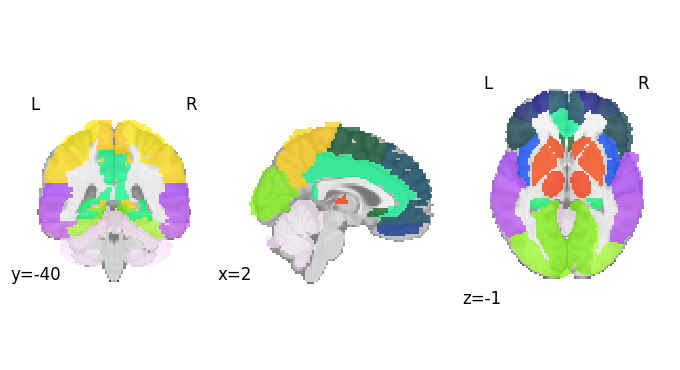

In [5]:
# Location of HarvardOxford parcellation atlas
atlas_file = atlas_ho.maps

# Visualize parcellation atlas
plotting.plot_roi(atlas_file, draw_cross=False, annotate=True);

In [6]:
print(len(atlas_ho.labels))

116


In [7]:
subject_labels = layout.get_subjects()

fmri_files=[]
for subject_label in subject_labels:
    file_name=f'../Full-Dataset/sub-{subject_label}/run.feat/filtered_func_data.nii.gz'
    fmri_files.append(file_name)

NameError: name 'layout' is not defined

In [61]:
len(fmri_files)

71

In [23]:
fmri_file=r"C:\Users\reub\Downloads\exmni_filtered_func_data.nii.gz"
# fmri_file=r"C:\Reuben's Code's\PyTorch\Schizophrenia\Full-Dataset\sub-12\func\sub-12_task-speech_bold.nii.gz"

In [24]:
fmri_data = image.load_img(fmri_file)

In [25]:
masker = maskers.NiftiLabelsMasker(labels_img=atlas_file, standardize='zscore_sample', verbose=0)

In [26]:
time_series = masker.fit_transform(fmri_data)

In [27]:
# Print the shape of the extracted time series data
print("Shape of time series data:", time_series.shape)

Shape of time series data: (336, 116)


In [28]:
corr_matrix=connectome.ConnectivityMeasure(kind='correlation', standardize='zscore_sample').fit_transform([time_series])[0]

In [29]:
corr_matrix.shape

(116, 116)

In [30]:
# Mask the main diagonal for visualization:
np.fill_diagonal(corr_matrix, 0)

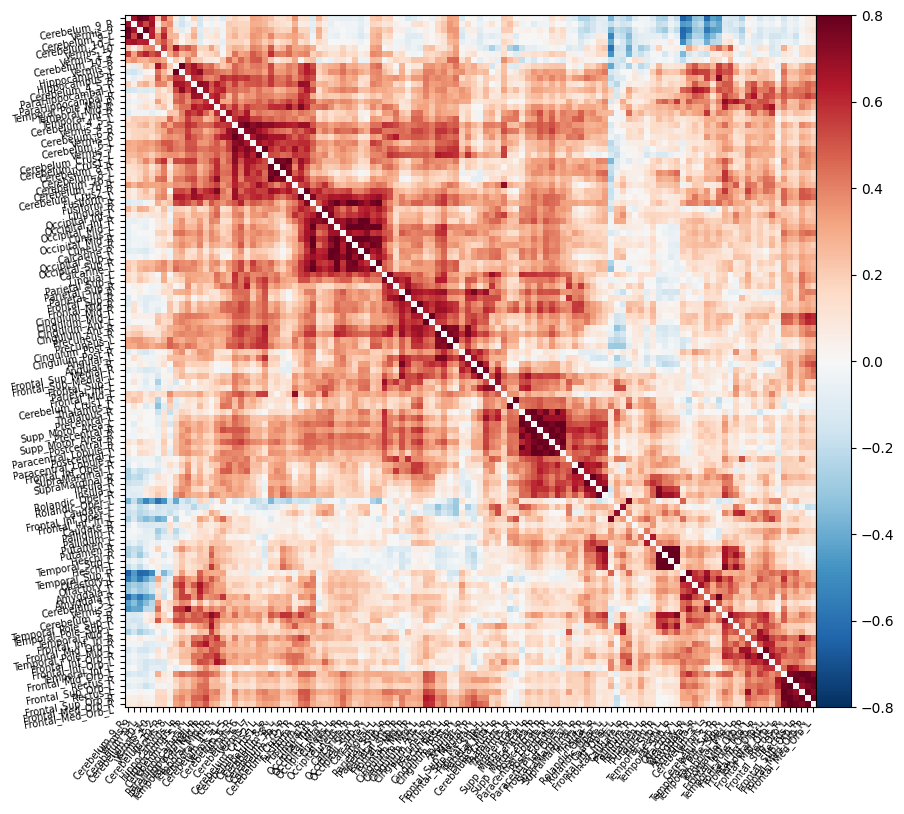

In [33]:
# Plot correlation matrix - note: matrix is ordered for block-like representation
plotting.plot_matrix(corr_matrix, figure=(10, 8), labels=atlas_ho.labels,
                     vmax=0.8, vmin=-0.8, reorder=True);

In [109]:
#base directory
def create_fc_matrices():
    fmriprep_dir='../Full-Dataset'
    layout=BIDSLayout(fmriprep_dir)
    # atlas_ho = datasets.fetch_atlas_aal('SPM12')
    atlas_ho= datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    # Location of the parcellation atlas
    atlas_file = atlas_ho.maps

    print(f'Number of labels in the atlas: {len(atlas_ho.labels)}\n')

    subject_labels = layout.get_subjects()

    fmri_files=[]
    for subject_label in subject_labels:
        file_name=f'../Full-Dataset/sub-{subject_label}/run.feat/filtered_func_data.nii.gz'
        fmri_files.append(file_name)
    
    print(f'Number of Subjects in the Dataset:{len(fmri_files)}\n')

    masker = maskers.NiftiLabelsMasker(labels_img=atlas_file, standardize='zscore_sample',resampling_target='label', verbose=0)
    correlation_measure = connectome.ConnectivityMeasure(kind='correlation',standardize='zscore_sample')

    subject_corr_data=[]
    time_series_data=[]

    for file in fmri_files:
        # print(file)
        fmri_data = image.load_img(file)
        time_series = masker.fit_transform(fmri_data)
        corr_matrix=correlation_measure.fit_transform([time_series])[0]
        # corr_matrix = np.corrcoef(time_series, rowvar=False)
        # np.fill_diagonal(corr_matrix, 0)
        time_series_data.append(time_series)
        subject_corr_data.append(corr_matrix)
        print(f'Subjects left to Compute {len(fmri_files)-len(subject_corr_data)}')
    
    return subject_corr_data, time_series_data

In [110]:
subject_corr_data, time_series_data=create_fc_matrices()

Number of labels in the atlas: 49

Number of Subjects in the Dataset:71

Subjects left to Compute 70


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 35, 37, 38, 39, 11, 14, 15, 16, 25}. Label image only contains 39 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 69
Subjects left to Compute 68
Subjects left to Compute 67


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {33, 34, 35, 37, 38, 39, 8, 9, 40, 11, 12, 44, 14, 15, 16, 25, 27}. Label image only contains 32 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 66
Subjects left to Compute 65


KeyboardInterrupt: 

In [93]:
np.save('../source_data/fc/parcelation_fc_matrix',subject_corr_data)
np.save('../source_data/time_series/parcelation_time_series',time_series_data)

In [4]:
subject_corr_data=np.load('../source_data/fc/parcelation_fc_matrix.npy')

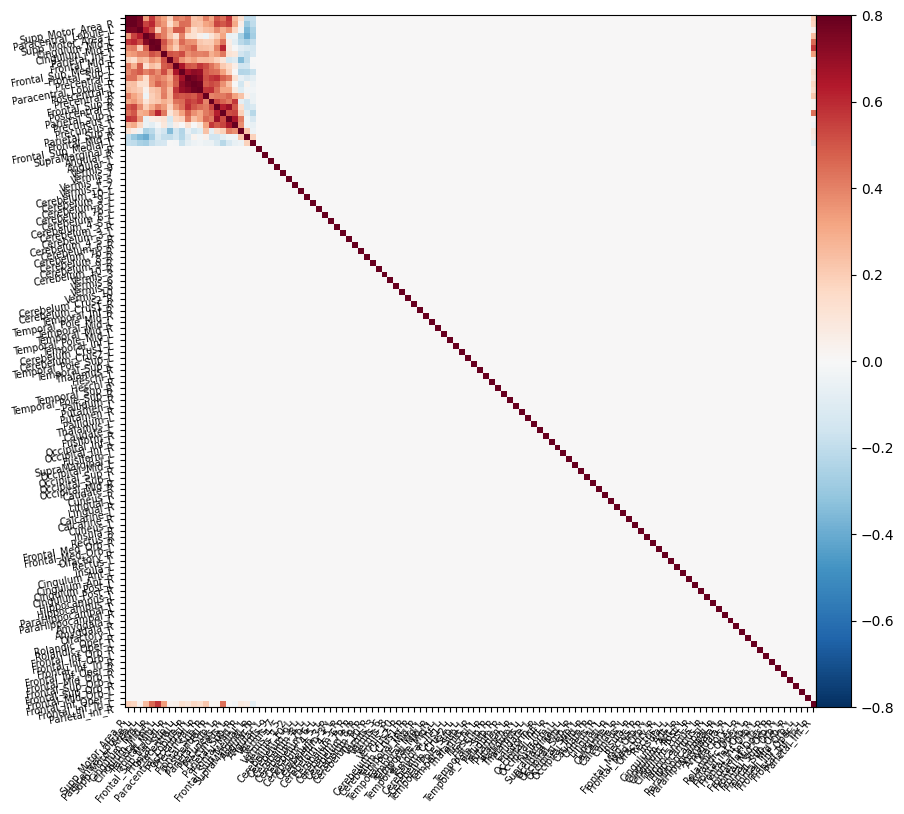

In [11]:
plotting.plot_matrix(subject_corr_data[11], figure=(10, 8), labels=atlas_ho.labels,
                     vmax=0.8, vmin=-0.8,reorder=True);

In [ ]:
def create_knn_graph(fc_matrices, k):
    # Calculate group FC matrix by averaging individual FC matrices
    group_fc_matrix = np.mean(fc_matrices, axis=0)

    # Calculate pairwise correlation coefficients
    mean_correlation_matrix = np.corrcoef(group_fc_matrix, rowvar=False)

    # Create k-NN graph
    G = nx.Graph()
    num_nodes = mean_correlation_matrix.shape[0]

    for i in range(num_nodes):
        # Find the indices of the top k edges in terms of connectivity strength
        top_k_indices = np.argsort(mean_correlation_matrix[i, :])[-k:]

        # Add edges to the graph
        for j in top_k_indices:
            if i != j:  # Avoid self-loops
                G.add_edge(i, j, weight=mean_correlation_matrix[i, j])

    return G, mean_correlation_matrix

In [ ]:
# k = 5
# knn_graph, mean_corr_matrix = create_knn_graph(fc_matrices, k)
# Extract adjacency matrix and labels
# adjacency_matrix = nx.adjacency_matrix(knn_graph).todense()
# labels = list(knn_graph.nodes)